<a href="https://colab.research.google.com/github/SoukainaElidrissi/NLP_text_Arabic/blob/main/Arabic_text_scraped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from collections import Counter

import string

import re

import seaborn as sns

from tqdm import tqdm

import matplotlib.pyplot as plt

import requests

from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [ ]:
def clean(soup):
    soup1 = str(soup)
    soup1 = re.sub(r'[A-Za-z0-9]', '', soup1)
    soup1 = re.sub(r'\n|\ufeff|\xa0|[^\w\s]', '', soup1)
    soup1 = re.sub(r"\d+", "", soup1)
    soup1 = re.sub(r"\s+", " ", soup1)
    soup1 = re.sub(r"#|@|_|é|è|à", "", soup1)
    return soup1

In [ ]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    return s

In [ ]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    for sent in x_train:
        words=sent.split(' ')
        for word in words:
            word = preprocess_string(word)
            if  word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    final_list_train,final_list_test = [],[]
    for sent in x_train:
        words=sent.split(' ')
        for word in words:
          if preprocess_string(word) in onehot_dict.keys():
            final_list_train.append([onehot_dict[preprocess_string(word)]])
    for sent in x_val:
      words=sent.split(' ')
      for word in words:
        if preprocess_string(word) in onehot_dict.keys():
            final_list_test.append([onehot_dict[preprocess_string(word)]])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_val),onehot_dict

In [ ]:
def padding_(sentences, seq_len):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)

    features = pad_sequences(sequences, maxlen=seq_len, padding='post')

    return features

In [ ]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
class LSTM(nn.Module):
    def __init__(self,vocab_size,no_layers=2,hidden_dim=256,embedding_dim=64,drop_prob=0.5,output_dim = 1):
        super(LSTM,self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        lstm_out, hidden = self.lstm(embeds, (h0, c0))
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [ ]:
url = 'https://sabq.org/stations/t93bfs'
url2 ='https://mawdoo3.com/%D8%AD%D9%82%D8%A7%D8%A6%D9%82_%D8%B9%D9%86_%D8%A7%D9%84%D8%A5%D9%86%D8%B3%D8%A7%D9%86'
response = requests.get(url)
response2 = requests.get(url2)
page_content = response.content
page2_content = response2.content

soup = BeautifulSoup(page_content, 'html.parser')
soup2 = BeautifulSoup(page2_content, 'html.parser')
parag = []
paragraph = soup.findAll('p')
paragraph2 = soup2.findAll('li')
for t in paragraph:
  parag.append(clean(t.text))
for t in paragraph2:
  parag.append(clean(t.text))
df = pd.DataFrame(parag)
df.columns=['Content']


In [ ]:
df.drop( [0,1,2,4,6,8,10,12,14,17,18,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,67,68,69,70,71,72,73,74,75,76,78,77,79,80,81,82,83,84,85,86,87,89,88,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120], inplace=True)

In [ ]:
Score10=[7.0,8.5,9.5,7.0,4.5,3.5,7.0,6.0,8.0,7.0,8.0,7.0,8.5,8.0,7.0,4.5,3.5,6.0,4.5,5.5,6.0,7.0,4.5,4.5,5.5,8.0,6.5,7.0,6.5]
Score = [score / 10 for score in Score10]
df['Score']=Score

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df

,Content,Score
0,في حقيقة علمية غريبة أثبتت الدراسات العلمية أن...,0.70
1,تتورد المعدة عندما يتورد الوجه أو الجسم عند ال...,0.85
2,يخفق قلبك حوالى مرة خلال اليوم الواحد ويضخ حوا...,0.95
3,عندما يدرك الدماغ أن الجسد يتضور جوعا يمكنه ال...,0.70
4,رغم التشكيك في صدق هذه المعلومة لكن بعض العلما...,0.45
5,يعاني بعض الأشخاص من متلازمة جورماند إثر إصابة...,0.35
6,تختلف تراكيب الدموع عند ذرفها إذا كان سببها ال...,0.70
7,العظام تتجدد باستمرار,0.60
8,تعمل الكلى على تصفية الدم حوالى مرة في اليوم ل...,0.80
9,يمكن للمعدة صنع حفرة في الجلد عندما تكون درجة ...,0.70


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_arabic_text(text):

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('arabic'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    stemmer = ISRIStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
X,y = df['Content'].values,df['Score'].values
X = X.astype(str)
y = y.astype(str)
x_train,x_test,y_train,y_test = train_test_split(X,y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (21,)
shape of test data is (8,)


In [ ]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)
print(f'Length of vocabulary is {len(vocab)}')
X,y = df['Content'].values,df['Score'].values
x_train,x_test,y_train,y_test = train_test_split(X,y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

Length of vocabulary is 283
shape of train data is (21,)
shape of test data is (8,)


In [ ]:
vocab

{'من': 1,
 'في': 2,
 'الجسم': 3,
 'الدماغ': 4,
 'على': 5,
 'عند': 6,
 'الإنسان': 7,
 'الدم': 8,
 'دماغ': 9,
 'إلى': 10,
 'أن': 11,
 'حوالي': 12,
 'أو': 13,
 'حوالى': 14,
 'وزن': 15,
 'جسم': 16,
 'يحتوي': 17,
 'عندما': 18,
 'خلايا': 19,
 'القلب': 20,
 'عن': 21,
 'مرة': 22,
 'اليوم': 23,
 'العمر': 24,
 'ويحدث': 25,
 'متوسط': 26,
 'أربعة': 27,
 'تقريبا': 28,
 'يمكن': 29,
 'والتي': 30,
 'الدموية': 31,
 'إصابة': 32,
 'الجلد': 33,
 'تكون': 34,
 'بعض': 35,
 'ما': 36,
 'الأرض': 37,
 'يقلل': 38,
 'التوتر': 39,
 'الفم': 40,
 'لترا': 41,
 'يوميا': 42,
 'كل': 43,
 'ويضخ': 44,
 'قلب': 45,
 'بشكل': 46,
 'أنه': 47,
 'ذلك': 48,
 'الأشخاص': 49,
 'تعمل': 50,
 'الكلى': 51,
 'تصفية': 52,
 'للحفاظ': 53,
 'صحة': 54,
 'يصبح': 55,
 'أصغر': 56,
 'كلما': 57,
 'تقدم': 58,
 'عادة': 59,
 'بعد': 60,
 'منتصف': 61,
 'يبلغ': 62,
 'الولادة': 63,
 'غراما': 64,
 'وينمو': 65,
 'أضعاف': 66,
 'حجمه': 67,
 'الأصلي': 68,
 'حتى': 69,
 'يصل': 70,
 'كيلو': 71,
 'ونصف': 72,
 'البلوغ': 73,
 'ويعد': 74,
 'الذكر': 75,
 'أكبر': 76,
 

In [ ]:
x_train_pad = padding_(x_train,50)
x_test_pad = padding_(x_test,50)

In [ ]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

# for sample_x, sample_y in train_loader:
#     print('Sample input size: ', sample_x.size())
#     print('Sample input: \n', sample_x)
#     print('Sample input: \n', sample_y)

In [ ]:
vocab_size = len(vocab) + 1
model = LSTM(vocab_size)
print(model)

LSTM(
  (embedding): Embedding(284, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

clip = 5
epochs = 5
valid_loss_min = np.Inf

In [ ]:
from google.colab import drive

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:


                inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])
        model.zero_grad()
        output,h = model(inputs,h)
                loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        accuracy = acc(output,labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])
            inputs, labels = inputs.to(device), labels.to(device)
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())
            val_losses.append(val_loss.item())
            accuracy = acc(output,labels)
            val_acc += accuracy
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        drive.mount('/content/drive')
        model_state_path = '/content/drive/MyDrive/state_dict.pt'
        torch.save(model.state_dict(), model_state_path)
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(50*'==')

Epoch 1
train_loss : 0.7001997828483582 val_loss : 0.6480207443237305
train_accuracy : 0.0 val_accuracy : 0.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Validation loss decreased (inf --> 0.648021).  Saving model ...
Epoch 2
train_loss : 0.6719094514846802 val_loss : 0.6112257838249207
train_accuracy : 0.0 val_accuracy : 0.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Validation loss decreased (0.648021 --> 0.611226).  Saving model ...
Epoch 3
train_loss : 0.6702033281326294 val_loss : 0.6094316244125366
train_accuracy : 0.0 val_accuracy : 0.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Validation loss decreased (0.611226 --> 0.609432).  Saving model ...
Epoch 4
train_loss : 0.675745964050293 val_loss : 0.6197885870933533
train_accura

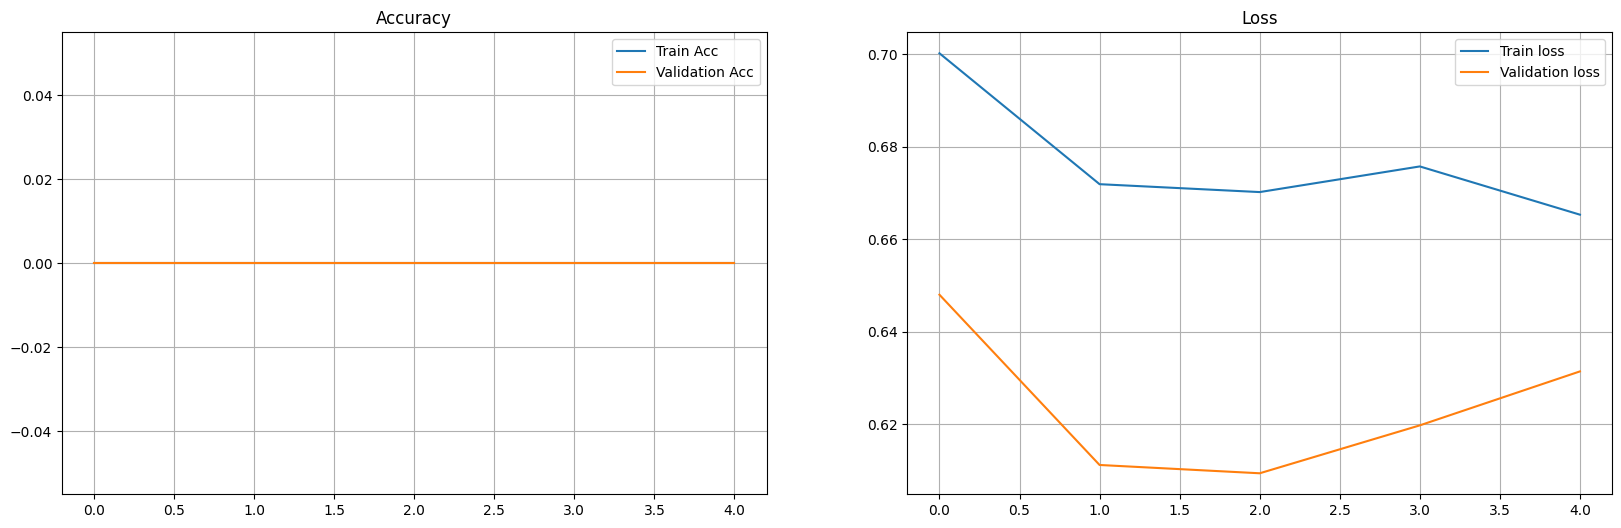

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])

        pad =  torch.from_numpy(padding_(str(word_seq),50))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        # pro = torch.sum(output).item()
        # pro = torch.mean(output).item()
        # return pro
        return(output.item())

In [ ]:
index = 15
print(df['Content'][index])
print('='*70)
print(f'Actual score is  : {df["Score"][index]}')
print('='*70)
pro = predict_text(df['Content'][index])

print(f'Predicted score is {pro}')

تعتبر إصابات الدماغ القوية من الأسباب الرئيسية للإعاقة والوفاة خاصة تلك الإصابات الناتجه عن السقوط وحوادث السيارات والاعتداءات
Actual score is  : 0.45
Predicted score is 0.5966193079948425


In [ ]:
index = 5
print(df['Content'][index])
print('='*70)
print(f'Actual sentiment is  : {df["Score"][index]}')
print('='*70)
pro = predict_text(df['Content'][index])

print(f'predicted score is {pro}')


يعاني بعض الأشخاص من متلازمة جورماند إثر إصابة في النصف الأيمن من الدماغ الأمامي وبسببها يبدؤون بتفضيل تناول الأطعمة الجيدة فقط
Actual sentiment is  : 0.35
predicted score is 0.5966192483901978
